In [79]:
!pip install pyreadstat
import pyreadstat
df_wave1, meta = pyreadstat.read_sav("Wave1_20170906.sav")
df_wave1.head(10)

,country,idnumber,level3,yrsurvey,se002,se003,se003a,se004,se004a,se005,...,ir010e,w_jp,w_hk,w_kr,w_cn,w_mo,w_ph,w_tw,w_th,w_all
0,4.0,1.0,1.0,2002.0,1.0,5.0,38.0,NaN,1.0,5.0,...,NaN,NaN,NaN,NaN,0.621390,NaN,NaN,NaN,NaN,0.62
1,4.0,2.0,1.0,2002.0,2.0,10.0,60.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.446785,NaN,NaN,NaN,NaN,0.45
2,4.0,3.0,1.0,2002.0,2.0,10.0,69.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,0.583658,NaN,NaN,NaN,NaN,0.58
3,4.0,4.0,1.0,2002.0,2.0,5.0,39.0,NaN,1.0,8.0,...,NaN,NaN,NaN,NaN,0.490000,NaN,NaN,NaN,NaN,0.49
4,4.0,5.0,1.0,2002.0,1.0,7.0,48.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.396647,NaN,NaN,NaN,NaN,0.40
5,4.0,6.0,1.0,2002.0,1.0,10.0,64.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.479041,NaN,NaN,NaN,NaN,0.48
6,4.0,7.0,1.0,2002.0,2.0,2.0,23.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,1.473766,NaN,NaN,NaN,NaN,1.47
7,4.0,8.0,1.0,2002.0,2.0,10.0,63.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,0.446785,NaN,NaN,NaN,NaN,0.45
8,4.0,9.0,1.0,2002.0,1.0,10.0,66.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,0.409378,NaN,NaN,NaN,NaN,0.41
9,4.0,10.0,1.0,2002.0,2.0,3.0,26.0,NaN,1.0,4.0,...,NaN,NaN,NaN,NaN,1.118153,NaN,NaN,NaN,NaN,1.12


In [80]:
import pandas as pd
data_dictionary = pd.read_csv("D2-ABS1+2.csv", header=1)

In [81]:
def select_important_columns(data_dictionary, dataset):
  col_names = data_dictionary["ABS1_Coding_name"][0:-6]
  return df_wave1[col_names]

In [82]:
merged_data = pd.merge(df_wave1[['country']], select_important_columns(data_dictionary, df_wave1))

In [83]:
merged_data.head()

,country,se002,se004,se005,se009,se003a,q007,q008,q009,q010,...,q098,q128,q005,q027,q028,q105,q106,q121,q123,q127
0,4.0,1.0,NaN,5.0,5.0,38.0,3.0,3.0,3.0,3.0,...,2.0,3.0,4.0,2.0,NaN,5.0,3.0,NaN,3.0,2.0
1,4.0,2.0,NaN,4.0,5.0,60.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0
2,4.0,2.0,NaN,1.0,5.0,69.0,4.0,4.0,4.0,4.0,...,NaN,NaN,3.0,NaN,NaN,2.0,3.0,NaN,NaN,3.0
3,4.0,2.0,NaN,8.0,5.0,39.0,4.0,4.0,4.0,4.0,...,3.0,3.0,2.0,2.0,NaN,5.0,3.0,NaN,3.0,NaN
4,4.0,1.0,NaN,4.0,5.0,48.0,4.0,4.0,4.0,4.0,...,NaN,2.0,3.0,NaN,NaN,4.0,3.0,NaN,3.0,2.0


In [84]:
merged_data.isna().sum()

country           0
se002         12368
se004      10154431
se005         68666
se009       1310033
se003a      1350731
q007        2481561
q008        1300395
q009        1130763
q010        1771056
q006        2710052
q098        2065936
q128        2689416
q005         133284
q027        4760657
q028       14673905
q105        1838917
q106        2347510
q121       10639269
q123        2048706
q127        2278003
dtype: int64

In [85]:
from pandas.api.types import CategoricalDtype
cat1 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=True)
cat2 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=True)
cat3 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0], ordered=True)
cat4 = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0], ordered=True)
for column in merged_data.columns:
  if column != "se003a":
    if column == "q006" or column == "q005":
      merged_data[column] = merged_data[column].astype(cat1)
    if column == "q105" or column == "q106" or column == "se009":
      merged_data[column] = merged_data[column].astype(cat2)
    if column == "q098" or column == "q123" or column == "q121" or column == "q127" or column == "q128":
      merged_data[column] = merged_data[column].astype(cat3)
    if column == "q008" or column == "q009" or column == "q010":
      merged_data[column] = merged_data[column].astype(cat4)
    merged_data[column] = merged_data[column].astype("category")

In [86]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
imputed_data = imp.fit_transform(merged_data)

In [87]:
imputed_data

array([[4., 1., 1., ..., 4., 3., 2.],
       [4., 2., 1., ..., 4., 3., 2.],
       [4., 2., 1., ..., 4., 3., 3.],
       ...,
       [8., 2., 1., ..., 3., 3., 2.],
       [8., 2., 1., ..., 4., 2., 1.],
       [8., 2., 1., ..., 4., 2., 2.]])

In [113]:
merged_imputed_data = pd.DataFrame(imputed_data, columns = merged_data.columns)
merged_imputed_data.head()

,country,se002,se004,se005,se009,se003a,q007,q008,q009,q010,...,q098,q128,q005,q027,q028,q105,q106,q121,q123,q127
0,4.0,1.0,1.0,5.0,5.0,38.0,3.0,3.0,3.0,3.0,...,2.0,3.0,4.0,2.0,807.0,5.0,3.0,4.0,3.0,2.0
1,4.0,2.0,1.0,4.0,5.0,60.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,2.0,807.0,3.0,3.0,4.0,3.0,2.0
2,4.0,2.0,1.0,1.0,5.0,69.0,4.0,4.0,4.0,4.0,...,3.0,2.0,3.0,2.0,807.0,2.0,3.0,4.0,3.0,3.0
3,4.0,2.0,1.0,8.0,5.0,39.0,4.0,4.0,4.0,4.0,...,3.0,3.0,2.0,2.0,807.0,5.0,3.0,4.0,3.0,2.0
4,4.0,1.0,1.0,4.0,5.0,48.0,4.0,4.0,4.0,4.0,...,3.0,2.0,3.0,2.0,807.0,4.0,3.0,4.0,3.0,2.0


In [25]:
merged_imputed_data.to_csv("merged&imputed.csv")

## EDA

In [114]:
merged_data.isna().sum()

country           0
se002         12368
se004      10154431
se005         68666
se009       1310033
se003a      1350731
q007        2481561
q008        1300395
q009        1130763
q010        1771056
q006        2710052
q098        2065936
q128        2689416
q005         133284
q027        4760657
q028       14673905
q105        1838917
q106        2347510
q121       10639269
q123        2048706
q127        2278003
dtype: int64

In [115]:
len(merged_data)

22191011

In [116]:
merged_imputed_data = merged_imputed_data.drop(['se004','q028', 'q121'], axis = 1)

In [117]:
merged_imputed_data

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q098,q128,q005,q027,q105,q106,q123,q127
0,4.0,1.0,5.0,5.0,38.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0
1,4.0,2.0,4.0,5.0,60.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0
2,4.0,2.0,1.0,5.0,69.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0
3,4.0,2.0,8.0,5.0,39.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,3.0,3.0,2.0
4,4.0,1.0,4.0,5.0,48.0,4.0,4.0,4.0,4.0,2.0,3.0,2.0,3.0,2.0,4.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22191006,8.0,2.0,2.0,2.0,27.0,3.0,2.0,2.0,3.0,4.0,3.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0
22191007,8.0,1.0,2.0,2.0,70.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,2.0
22191008,8.0,2.0,3.0,5.0,37.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0,4.0,4.0,3.0,2.0
22191009,8.0,2.0,2.0,1.0,58.0,3.0,3.0,4.0,4.0,3.0,3.0,2.0,3.0,2.0,4.0,4.0,2.0,1.0


In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
import seaborn as sns

C:\Users\jhlda\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='se003a', ylabel='Density'>

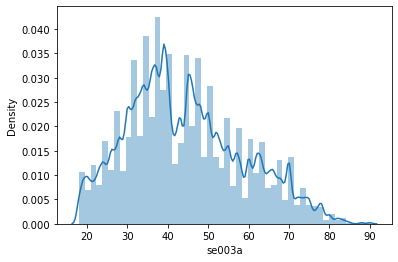

In [39]:
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==4.0]['se003a'])

In [38]:
merged_imputed_data.loc[merged_imputed_data['country']==4.0]['se003a']

0           38.0
1           60.0
2           69.0
3           39.0
4           48.0
            ... 
10131484    42.0
10131485    65.0
10131486    64.0
10131487    40.0
10131488    32.0
Name: se003a, Length: 10131489, dtype: float64

In [95]:
cat1 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=True)
cat2 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=True)
cat3 = CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0], ordered=True)
cat4 = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0], ordered=True)
for column in merged_imputed_data.columns:
  if column != "se003a":
    if column == "q006" or column == "q005":
      merged_imputed_data[column] = merged_imputed_data[column].astype(cat1)
    if column == "q105" or column == "q106" or column == "se009":
      merged_imputed_data[column] = merged_imputed_data[column].astype(cat2)
    if column == "q098" or column == "q123" or column == "q121" or column == "q127" or column == "q128":
      merged_imputed_data[column] = merged_imputed_data[column].astype(cat3)
    if column == "q008" or column == "q009" or column == "q010":
      merged_imputed_data[column] = merged_imputed_data[column].astype(cat4)
    merged_imputed_data[column] = merged_imputed_data[column].astype("category")

In [120]:
merged_imputed_data['q105'].value_counts()

4.0    13020916
5.0     5174586
3.0     2854096
2.0      943940
1.0      197473
Name: q105, dtype: int64

In [97]:
merged_imputed_data.head()

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q098,q128,q005,q027,q105,q106,q123,q127
0,4.0,1.0,5.0,5.0,38.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0
1,4.0,2.0,4.0,5.0,60.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0
2,4.0,2.0,1.0,5.0,69.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0
3,4.0,2.0,8.0,5.0,39.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,3.0,3.0,2.0
4,4.0,1.0,4.0,5.0,48.0,4.0,4.0,4.0,4.0,2.0,3.0,2.0,3.0,2.0,4.0,3.0,3.0,2.0


In [98]:
import warnings
warnings.filterwarnings('ignore')

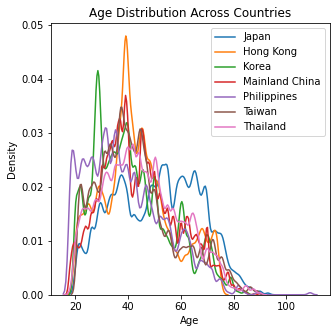

In [65]:
plt.figure(figsize=(5,5))
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==1.0]['se003a'], hist=False, label = "Japan")
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==2.0]['se003a'], hist=False, label = "Hong Kong")
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==3.0]['se003a'], hist=False, label = "Korea")
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==4.0]['se003a'], hist=False, label = "Mainland China")
#Mogolia has no age distribution
#sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==5.0]['se003a'])
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==6.0]['se003a'], hist=False, label = "Philippines")
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==7.0]['se003a'], hist=False, label = "Taiwan")
sns.distplot(merged_imputed_data.loc[merged_imputed_data['country']==8.0]['se003a'], hist=False, label = "Thailand")
plt.title("Age Distribution Across Countries")
plt.legend()
plt.xlabel("Age")
plt.show()

Text(0.5, 0.98, 'Country vs. Democracy')

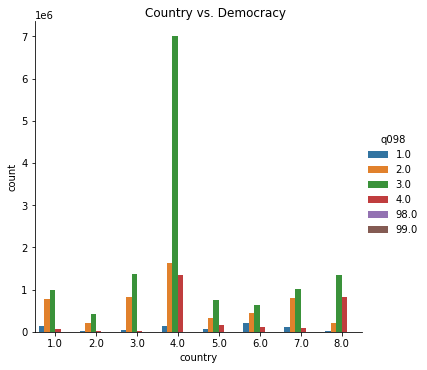

In [67]:
sns.catplot(x="country", hue="q098", data=merged_imputed_data, kind="count")
plt.suptitle("Country vs. Democracy")

In [99]:
#merged_imputed_data.drop(['q008', 'q009'], axis = 1, inplace=True)

In [100]:
merged_imputed_data.head()

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q098,q128,q005,q027,q105,q106,q123,q127
0,4.0,1.0,5.0,5.0,38.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0
1,4.0,2.0,4.0,5.0,60.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0
2,4.0,2.0,1.0,5.0,69.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0
3,4.0,2.0,8.0,5.0,39.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,3.0,3.0,2.0
4,4.0,1.0,4.0,5.0,48.0,4.0,4.0,4.0,4.0,2.0,3.0,2.0,3.0,2.0,4.0,3.0,3.0,2.0


## Bootstrapping, Subsetting the Meta Data

In [150]:
sample = merged_imputed_data.groupby("country").sample(n = 10000, replace = True, random_state = 0).reset_index(drop=True)
sample.head()

,country,se002,se005,se009,se003a,q007,q008,q009,q010,q006,q098,q128,q005,q027,q105,q106,q123,q127
0,1.0,2.0,7.0,3.0,42.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,2.0,4.0,4.0,4.0,2.0
1,1.0,2.0,8.0,2.0,49.0,3.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,2.0,5.0,4.0,4.0,2.0
2,1.0,1.0,8.0,3.0,40.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,5.0,3.0,4.0,3.0
3,1.0,2.0,7.0,1.0,29.0,3.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,1.0,5.0,5.0,4.0,1.0
4,1.0,1.0,8.0,5.0,23.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,2.0,4.0,4.0,4.0,2.0


## Feature Selection

### Backward Elimination Feature Importance Test

In [151]:
selected_columns = sample.drop(['q098'], axis = 1).columns.values
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
 
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(sample.drop(['q098'], axis = 1).values, sample.loc[:,"q098"].values, SL, selected_columns)
selected_columns

array(['country', 'se002', 'se005', 'se009', 'se003a', 'q007', 'q008',
       'q009', 'q010', 'q006', 'q128', 'q005', 'q027', 'q105', 'q106',
       'q123'], dtype=object)

### Chi-squared Feature Importance Test

In [152]:
X = sample.drop(["q098"], axis = 1)
y = sample.loc[:,"q098"]
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=11)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
chi_feature

['country',
 'se005',
 'q007',
 'q008',
 'q009',
 'q010',
 'q006',
 'q005',
 'q105',
 'q106',
 'q127']

### F-score Feature Importance Test

In [153]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=10)
kb.fit(X, y.values.ravel())
names = X.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores','Feat_names'], ascending =[False, True])
print(ns_df_sorted)

  Feat_names     F_Scores
3       q008  2298.560487
5       q010  2204.266291
4       q009  1894.020258
9       q106  1790.734317
2       q007  1691.142071
0    country  1575.428548
1      se005  1568.356294
8       q105   604.395367
6       q006   541.796066
7       q005   475.849604


### Train Test Split

In [154]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=
0.3, random_state=0)

### Baseline Model: Random Forest

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [156]:
base_random_forest = RandomForestClassifier(n_jobs = -1, random_state=0)
base_random_forest.fit(X_train, y_train.values.ravel())
base_random_forest.score(X_test, y_test.values.ravel())

0.9932083333333334

In [157]:
base_random_forest.score(X_train, y_train.values.ravel())

0.9999464285714286

### Per class confusion matrix

In [158]:
from sklearn.metrics import confusion_matrix
y_true = y_test.values.ravel()
y_pred = base_random_forest.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 1121,     2,     2,     0],
       [    0,  6785,    71,     1],
       [    0,    16, 13526,    11],
       [    0,     0,    60,  2405]], dtype=int64)

## Tuning Random Forest Model

To tune the parameters of the random forest, we plan to use the randomized search cross validation to find the best set of parameters within that range. Once we have done so, we will re-fit the random forest model with new parameters.

In [160]:
n_estimators = [int(x) for x in np.linspace(100, 500, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, 2)]
min_samples_leaf = [int(x) for x in np.linspace(0, 10, 2)]
bootstrap = [True, False]

In [161]:
#turn the arrays into a grid dictionary
random_grid = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf,
 'bootstrap': bootstrap}

In [164]:
from sklearn.model_selection import RandomizedSearchCV
#class-weight set to balanced to avoid issues brought by imbalanced dataset
model = RandomForestClassifier(n_jobs = -1, random_state=0)
# 3 fold cross validation on 100 combinations of random forest parameters
random_search_model = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
random_search_model.fit(X_train, y_train)
random_search_model.best_params_ #get the best combination of parameters

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

Now, the grid is fed to the model. The RandomizedSearchCV model will utilize the random forest classifier and implement 3-fold cross-validations on 100 combinations of model parameters.

In [170]:
#set up the random forest model with tuned parameters and fit the training data
Forest = RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators= 500, 
                                min_samples_split = 10, min_samples_leaf = 10, 
                                max_features = 'sqrt', max_depth=90, bootstrap = False).fit(X_train, y_train.values.ravel())

In [171]:
Forest.score(X_train, y_train)

0.9614285714285714

In [172]:
Forest.score(X_test, y_test)

0.9342916666666666

In [173]:
y_true = y_test.values.ravel()
y_pred = base_random_forest.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 1121,     2,     2,     0],
       [    0,  6785,    71,     1],
       [    0,    16, 13526,    11],
       [    0,     0,    60,  2405]], dtype=int64)

This decrease in accuracy is expected as the baseline model's depth of the trees is a lot larger than the tuned model, which
brought up the overfitting problem.
We deliberately shrinked the depth of each tree in the random forest in order to avoid overfitting issue, which caused the counts of false positives to increase.